In [1]:
using Rocket, ReactiveMP, GraphPPL
using Random, BenchmarkTools, Distributions, MacroTools, LinearAlgebra
using Plots

In [2]:
function rand_vec(rng, distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(rng, distribution) ] = 1.0
    s
end

function generate_data(n_samples; seed = 124)
    
    rng = MersenneTwister(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 
    # Initial state
    s_0 = [1.0, 0.0, 0.0] 
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(rng, Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(rng, Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [3]:
# Test data
N = 100
x_data, s_data = generate_data(N);

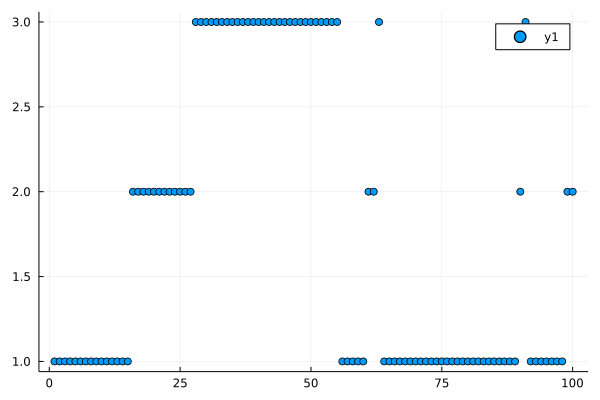

In [4]:
scatter(argmax.(s_data))

In [5]:
# Model specification
@model function hidden_markov_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) 
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
end

@constraints function hidden_markov_model_constraints()
    q(s_0, s, A, B) = q(s_0, s)q(A)q(B)
end

hidden_markov_model_constraints (generic function with 1 method)

In [6]:
imodel = () -> hidden_markov_model(N, options = (limit_stack_depth = 500, ), constraints = hidden_markov_model_constraints())

idata = (x = x_data, )

imarginals = (
    A = vague(MatrixDirichlet, 3, 3), 
    B = vague(MatrixDirichlet, 3, 3), 
    s = vague(Categorical, 3)
)

ireturnvars = (
    A = KeepLast(),
    B = KeepLast(),
    s = KeepLast()
)

result = inference(
    model         = imodel, 
    data          = idata, 
    initmarginals = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 20, 
    free_energy   = true
)

Inference results:
-----------------------------------------
Free Energy: Real[132.198, 125.35, 120.523, 113.37, 99.2503, 84.8829, 80.6348, 79.6174, 79.1632, 78.9335, 78.8291, 78.7876, 78.7729, 78.768, 78.7666, 78.7661, 78.766, 78.766, 78.766, 78.766]
-----------------------------------------
A = Marginal(MatrixDirichlet{Float64, Matrix{Float64}}(
a: [50.77712567849792 1.5084...
s = Marginal[Marginal(Categorical{Float64, Vector{Float64}}(support=Base.OneTo(3), p...
B = Marginal(MatrixDirichlet{Float64, Matrix{Float64}}(
a: [59.78624669132068 1.1776...


In [7]:
mean(result.posteriors[:A])

3×3 Matrix{Float64}:
 0.892911   0.0830398  0.133822
 0.0858821  0.691112   0.042798
 0.0212073  0.225849   0.82338

In [8]:
mean(result.posteriors[:B])

3×3 Matrix{Float64}:
 0.908176   0.0422229  0.0718142
 0.0694807  0.882211   0.0430307
 0.0223437  0.0755656  0.885155

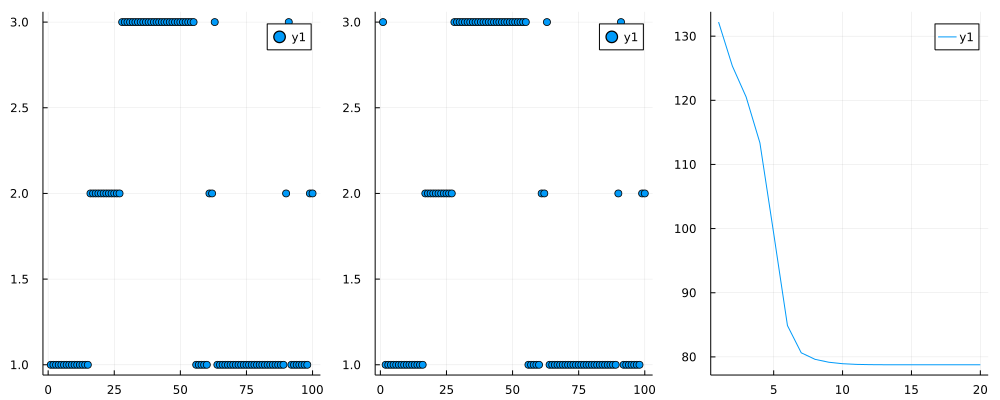

In [9]:
p1 = scatter(argmax.(s_data))
p2 = scatter(argmax.(ReactiveMP.probvec.(result.posteriors[:s])))
p3 = plot(result.free_energy)

plot(p1, p2, p3, size = (1000, 400), layout = @layout([ a b c ]))

In [10]:
@model [ default_factorisation = MeanField() ] function custom_optimised_hidden_markov_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

custom_optimised_hidden_markov_model (generic function with 1 method)

In [11]:
function custom_optimised_inference(data, vmp_iters)
    n = length(data)
    
    model, (s, x, A, B) = custom_optimised_hidden_markov_model(n, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    for i in 1:vmp_iters
        update!(x, data)
    end
    
    unsubscribe!(ssub)
    unsubscribe!(Asub)
    unsubscribe!(Bsub)
    unsubscribe!(fesub)
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

custom_optimised_inference (generic function with 1 method)

In [12]:
sbuffer, Abuffer, Bbuffer, fe = custom_optimised_inference(x_data, 20);

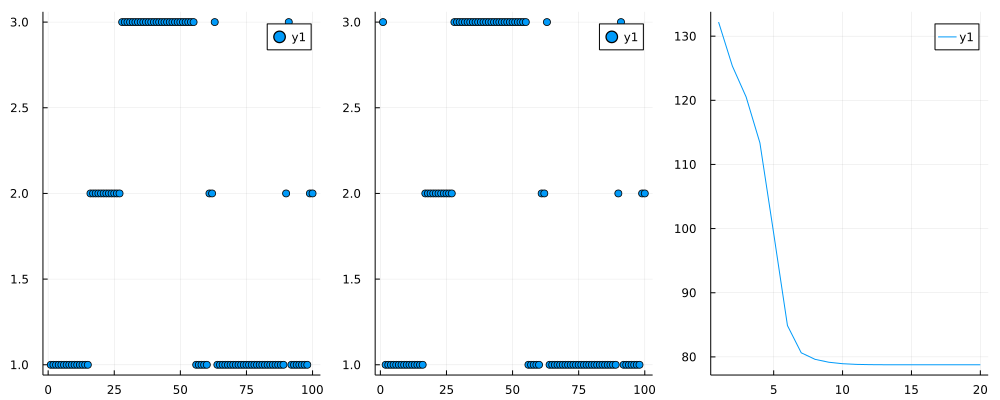

In [13]:
p1 = scatter(argmax.(s_data))
p2 = scatter(argmax.(ReactiveMP.probvec.(last(sbuffer))))
p3 = plot(fe)

plot(p1, p2, p3, size = (1000, 400), layout = @layout([ a b c ]))

In [14]:
@assert mean.(last(sbuffer)) ≈ mean.(result.posteriors[:s])

# Benchmark timings

In [15]:
@time inference(model = imodel, data = idata, initmarginals = imarginals, returnvars = ireturnvars, iterations = 20, free_energy = true);
@time inference(model = imodel, data = idata, initmarginals = imarginals, returnvars = ireturnvars, iterations = 20, free_energy = true);

  0.035410 seconds (443.79 k allocations: 27.808 MiB)
  0.034820 seconds (443.79 k allocations: 27.808 MiB)


In [16]:
@benchmark inference(model = $imodel, data = $idata, initmarginals = $imarginals, returnvars = $ireturnvars, iterations = 20, free_energy = true)

BenchmarkTools.Trial: 130 samples with 1 evaluation.
 Range (min … max):  30.363 ms … 51.809 ms  ┊ GC (min … max): 0.00% … 21.10%
 Time  (median):     35.948 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   38.613 ms ±  5.841 ms  ┊ GC (mean ± σ):  9.33% ± 11.20%

      ▁   ▃ █▃█▄▃█ ▆▃▁                     ▁    ▄              
  ▄▆▁▆█▇▇▆█▇██████▆███▁▁▁▁▆▁▁▁▁▁▄▄▄▁▇▄▆▁▁▁▆█▇▁▇▆█▆▆▆▇▄▄▁▁▁▆▄▄ ▄
  30.4 ms         Histogram: frequency by time          51 ms <

 Memory estimate: 27.81 MiB, allocs estimate: 443785.

In [17]:
@time sbuffer, Abuffer, Bbuffer, fe = custom_optimised_inference(x_data, 20);
@time sbuffer, Abuffer, Bbuffer, fe = custom_optimised_inference(x_data, 20);

  0.041282 seconds (413.95 k allocations: 26.311 MiB)
  0.064649 seconds (413.95 k allocations: 26.311 MiB, 39.87% gc time)


In [18]:
@benchmark custom_optimised_inference($x_data, 20)

BenchmarkTools.Trial: 136 samples with 1 evaluation.
 Range (min … max):  29.459 ms … 49.457 ms  ┊ GC (min … max): 0.00% … 25.19%
 Time  (median):     33.899 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   36.969 ms ±  6.147 ms  ┊ GC (mean ± σ):  9.88% ± 12.01%

         ▅▂█▂▇ ▅                                               
  ▇▅▁▇▅▃▇█████▇█▇▃▃▆██▁▃▁▁▃▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▃▁▁▁▇▅▅▆▇▇▇▅▆█▃▇▁▃▃ ▃
  29.5 ms         Histogram: frequency by time        48.5 ms <

 Memory estimate: 26.31 MiB, allocs estimate: 413948.